# Data  <a class="anchor" id="data-overview"></a>
These data have been provided by the Georgia State University and the Learning Agency Lab for the Kaggle competition, “Feedback Prize – Predicting Effective Arguments”, They contain argumentative essays written by U.S. students in grades 6-12. Each essay has been annotated with discourse elements  commonly found in argumentative writing:
- Lead - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
- Position - an opinion or conclusion on the main question
- Claim - a claim that supports the position
- Counterclaim - a claim that refutes another claim or gives an opposing reason to the position
- Rebuttal - a claim that refutes a counterclaim
- Evidence - ideas or examples that support claims, counterclaims, or rebuttals.
- Concluding Statement - a concluding statement that restates the claims

The text classification task is to predict the quality of each discourse within each essay as one of:
- Ineffective
- Adequate
- Effective

The dataset is comprised of training data and example test data.

**Training Data**
The training dataset consists of a .csv file and a directory containing the full-text essays. Note, that parts of the full-text essays are not annotated and are not part of the training.csv file. Annotated discourse elements for each essay, including:     
- discourse_id - ID code for discourse element     
- essay_id - ID code for essay response. This ID code corresponds to the name of the full-text file in the train/ folder.     
- discourse_text - Text of discourse element.     
- discourse_type - Class label of discourse element.     
- discourse_type_num - Enumerated class label of discourse element.   
- discourse_effectiveness - Quality rating of discourse element, the target.      

**Example Test Data**
The example test data consists of:    
- test/ - A folder containing an example essay from the test set. The actual test set comprises about 3,000 essays in a format similar to the training set essays.    
- test.csv - Annotations for the test set essays, containing all of the fields of train.csv except the target, discourse_effectiveness.   
- sample_submission.csv - A sample submission file in the correct format.    

### Parameters <a class="anchor" id="parameters"></a>

### Package Dependency Installation <a class="anchor" id="installation"></a>

In [2]:
# Uncomment to install required packages
#%%capture
# !conda install -S -q -c conda-forge -y pandas
# !conda install -S -q -c conda-forge -y matplotlib
# !conda install -S -q -c conda-forge -y numpy
# !conda install -S -q -c conda-forge -y nltk
# !conda install -S -q -c conda-forge -y seaborn
# !conda install -S -q -c conda-forge -y scikit-learn
# !conda install -S -q -c conda-forge -y gensim
# !conda install -S -q -c conda-forge -y pyldavis
# !conda install -S -q -c conda-forge -y wordcloud
# !conda install -S -q -c conda-forge -y textblob
# !conda install -S -q -c conda-forge -y spacy
# !conda install -S -q -c conda-forge -y textstat


### Package Imports <a class="anchor" id="packages"></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import logging.config
import nltk
from IPython.display import display, HTML
# import spacy
# import os
# import unicodedata
# import sklearn as skl
# import gensim
# import pyLDAvis
# import wordcloud
# import textblob
# import textstat

/home/john/anaconda3/envs/fpe/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Module Imports <a class="anchor" id="modules"></a>

In [4]:
# Local Imports 
from fpe.utils.log_config import LOG_CONFIG
from fpe.data.profile import TextProfiler, FeatureExtractor
from fpe.utils.pprint import print_int as pint
from fpe.utils.pprint import print_float as pfloat
%matplotlib inline

### Configurations <a class="anchor" id="config"></a>

In [5]:
# Package specific dependencies
logging.config.dictConfig(LogConfig().config)
logger = logging.getLogger(__name__)

# Seaborn
sns.set_palette("Blues_r")
sns.set_style("whitegrid")

# NLTK 
if not os.path.exists(NLTK_PUNKT_DIR):
    nltk.download('punkt')
if not os.path.exists(NLTK_STOPWORDS_DIR):
    nltk.download('stopwords')

# Pandas
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_colwidth", 5000)


[nltk_data] Downloading package punkt to /home/john/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to /home/john/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Inspection <a class="anchor" id="inspect"></a>
Our intent with this inspection of the training set is to get a sense of the features and quality of the data. Here, we examine cardinality, character, word, and sentence counts, special characters, and any aspects having text preprocessing implications. Let's read the data.

In [6]:
fpe = pd.read_csv(RAW_TRAIN_DISCOURSE, encoding='utf-8')


### Overview <a class="anchor" id="overview"></a>
The essential dataset is the train.csv file, containing discourse and essay identifiers, the discourse text, the discourse type, and finally the rating.

In [7]:
fpe.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,Adequate


### Cardinality <a class="anchor" id="cardinality"></a>
Let's check the cardinality of discourses, essays, texts, types, and effectiveness ratings. From this point forward, we'll use our TextProfiler object to extract features from the data.

In [8]:
profiler = TextProfiler(data=fpe, text_col='discourse_text')
profiler.cardinality

,Cardinality
discourse_id,36765
essay_id,4191
discourse_text,36691
discourse_type,7
discourse_effectiveness,3


It seems we have some duplication in discourse text as we have 74 fewer unique essays than discourse identifiers. Let's examine this a bit closer.

In [9]:
profiler.duplicate_text['stats']
profiler.duplicate_text['data']


,Num Duplicates,Pct Duplicates
Column,,
discourse_text,119,0.32


296      The use of the Facial Action Coding System to read the emotional expressions of students in a classroom is valuable 
370                                                                               Summer projects should be teacher-designed 
1009                                                                              Summer projects should be teacher-designed 
1552                                                                              Summer projects should be teacher-designed 
1667                                                                              Summer projects should be student-designed 
                                                                 ...                                                         
35488                                                                                                   you can help others. 
35493                                                                                                   you can help o

We have over one hundred duplicates, counting all records that are duplicate. A small proportion; yet, we'll need to deal with these duplicates during the preprocessing stage.

### Value Counts <a class="anchor" id="value_counts"></a>
Here we examine the distribution of discourse types and effectiveness ratings.

#### Discourse Types

,discourse_type_count,discourse_type_ratio
Evidence,12105,0.33
Claim,11977,0.33
Position,4024,0.11
Concluding Statement,3351,0.09
Lead,2291,0.06
Counterclaim,1773,0.05
Rebuttal,1244,0.03


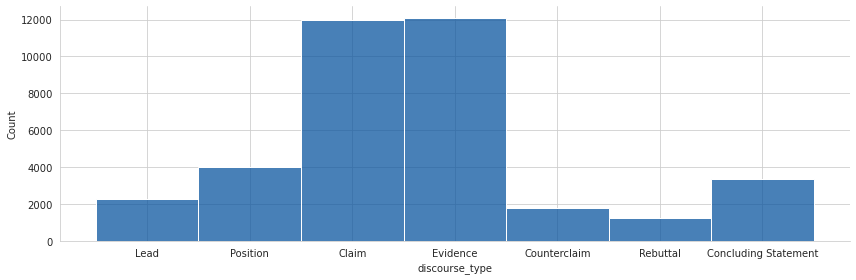

In [10]:
fig = sns.displot(fpe['discourse_type'], height=FIG_HEIGHT, aspect=FIG_ASPECT)
profiler.value_counts(col='discourse_type')


About 2/3rd of the essays contain claim and evidence discourse types. The fact that 89% of the argument papers fail to state a position (according to annotators) raises quality of education issues, but that's a topic for another paper.

#### Effectiveness Ratings 

,discourse_effectiveness_count,discourse_effectiveness_ratio
Adequate,20977,0.57
Effective,9326,0.25
Ineffective,6462,0.18


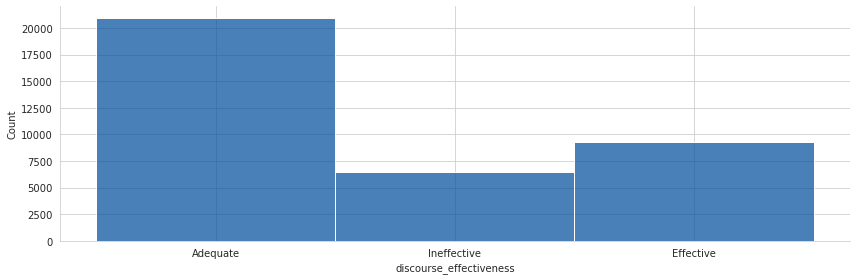

In [11]:
fig = sns.displot(fpe['discourse_effectiveness'], height=FIG_HEIGHT, aspect=FIG_ASPECT)
profiler.value_counts(col='discourse_effectiveness')

Well, in Lake Wobegon, all the children are above average.

### Null Values <a class="anchor" id="nulls"></a>

In [12]:
fpe.isnull().sum()

discourse_id               0
essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
dtype: int64

### Memory Size <a class="anchor" id="memory"></a>

In [13]:
profiler.memory

,Column,Memory (Bytes)
0,discourse_id,"2,536,785"
1,essay_id,"2,536,785"
2,discourse_text,"12,537,564"
3,discourse_type,"2,391,934"
4,discourse_effectiveness,"2,418,437"
6,Total,"22,421,505"


### Alphabetic Characters <a class="anchor" id="alpha"></a>